In [ ]:
import pandas as pd
from pathlib import Path
import os
from dotenv import load_dotenv
import plotly.express as px
import numpy as np
from transformers import pipeline
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
load_dotenv()  # carrega as variáveis do .env
path = Path(os.getenv("DATASETS_PATH"))

books = pd.read_csv(os.path.join(path, "books_cleaned.csv"))

In [8]:
books.head(10)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
5,9780006380832,0006380832,Empires of the Monsoon,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0,Empires of the Monsoon: A History of the India...,9780006380832 Until Vasco da Gama discovered t...
6,9780006470229,000647022X,The Gap Into Madness,Stephen R. Donaldson,"Hyland, Morn (Fictitious character)",http://books.google.com/books/content?id=4oXav...,A new-cover reissue of the fourth book in the ...,1994.0,4.15,743.0,103.0,The Gap Into Madness: Chaos and Order,9780006470229 A new-cover reissue of the fourt...
7,9780006472612,0006472613,Master of the Game,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0,Master of the Game,9780006472612 Kate Blackwell is an enigma and ...
8,9780006482079,0006482074,Warhost of Vastmark,Janny Wurts,Fiction,http://books.google.com/books/content?id=uOL0f...,"Tricked once more by his wily half-brother, Ly...",1995.0,4.03,522.0,2966.0,Warhost of Vastmark,9780006482079 Tricked once more by his wily ha...
9,9780006483014,0006483011,The Once and Future King,Terence Hanbury White,Arthurian romances,http://books.google.com/books/content?id=Jx6Bv...,An omnibus volume of the author's complete sto...,1996.0,4.04,823.0,2805.0,The Once and Future King,9780006483014 An omnibus volume of the author'...


In [18]:
# Verifica a quantidade de valores para cada uma das cateogiras da classificação dos livros
books["categories"].value_counts().reset_index()

,categories,count
0,Fiction,2111
1,Juvenile Fiction,390
2,Biography & Autobiography,311
3,History,207
4,Literary Criticism,124
...,...,...
474,Aged women,1
475,Imperialism,1
476,Human-animal relationships,1
477,Amish,1


- Não é bom ter muitas classificações de livros, sendo que algumas podem ser similar a outras. O objetivo é dimiuir essa quantidade e também não termos categorias com valores baixos.

In [27]:
top_categories = books["categories"].value_counts().head(20).reset_index()
top_categories.columns = ["Categoria", "Quantidade"]

fig = px.bar(
    top_categories,
    x="Categoria",
    y="Quantidade",
    title="Quantidade de livros por categoria"
)

fig.update_layout(xaxis_title="Categorias", yaxis_title="Quantidade de livros")
fig.show()


- No gráfico acima mostra que entre as 20 maiores classificações temos algumas categorias em comum, como Juvenile Fiction e Fiction e algumas dentre essas 20 categorias com poucas repetições, por exemplo a Art tem apenas 32.
- Na primeira tentativa será colocado apenas as classificações fiction e nonfiction

In [28]:
category_mapping = {'Fiction' : "Fiction",
 'Juvenile Fiction': "Children's Fiction",
 'Biography & Autobiography': "Nonfiction",
 'History': "Nonfiction",
 'Literary Criticism': "Nonfiction",
 'Philosophy': "Nonfiction",
 'Religion': "Nonfiction",
 'Comics & Graphic Novels': "Fiction",
 'Drama': "Fiction",
 'Juvenile Nonfiction': "Children's Nonfiction",
 'Science': "Nonfiction",
 'Poetry': "Fiction"}

books["simple_categories"] = books["categories"].map(category_mapping)

In [34]:
books[~(books["simple_categories"].isna())]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
8,9780006482079,0006482074,Warhost of Vastmark,Janny Wurts,Fiction,http://books.google.com/books/content?id=uOL0f...,"Tricked once more by his wily half-brother, Ly...",1995.0,4.03,522.0,2966.0,Warhost of Vastmark,9780006482079 Tricked once more by his wily ha...,Fiction
30,9780006646006,000664600X,Ocean Star Express,Mark Haddon;Peter Sutton,Juvenile Fiction,http://books.google.com/books/content?id=I2QZA...,Joe and his parents are enjoying a summer holi...,2002.0,3.50,32.0,1.0,Ocean Star Express,9780006646006 Joe and his parents are enjoying...,Children's Fiction
46,9780007121014,0007121016,Taken at the Flood,Agatha Christie,Fiction,http://books.google.com/books/content?id=3gWlx...,A Few Weeks After Marrying An Attractive Young...,2002.0,3.71,352.0,8852.0,Taken at the Flood,9780007121014 A Few Weeks After Marrying An At...,Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,9781933648279,1933648279,Night Has a Thousand Eyes,Cornell Woolrich,Fiction,http://books.google.com/books/content?id=3Gk6s...,"""Cornell Woolrich's novels define the essence ...",2007.0,3.77,344.0,680.0,Night Has a Thousand Eyes,"9781933648279 ""Cornell Woolrich's novels defin...",Fiction
5188,9784770028969,4770028962,Coin Locker Babies,村上龍,Fiction,http://books.google.com/books/content?id=87DJw...,Rescued from the lockers in which they were le...,2002.0,3.75,393.0,5560.0,Coin Locker Babies,9784770028969 Rescued from the lockers in whic...,Fiction
5189,9788122200850,8122200850,"Cry, the Peacock",Anita Desai,Fiction,http://books.google.com/books/content?id=_QKwV...,This book is the story of a young girl obsesse...,1980.0,3.22,218.0,134.0,"Cry, the Peacock",9788122200850 This book is the story of a youn...,Fiction
5195,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction


- Com a nova classificação temos 3.743 valores a serem classificados e é uma boa base para teste.

In [50]:
# Utilizando a GPU e o modelo zero-shot-classification do facebook do Hugging Face

fiction_categories = ["Fiction", "Nonfiction"]

# Define o uso de GPU (True) ou CPU (False)
use_gpu = torch.cuda.is_available()

pipe = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if use_gpu else -1
)

Device set to use cuda:0


In [52]:
# Tese com o primeiro livro
sequence = books.loc[books["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[0]
pipe(sequence, fiction_categories)

{'sequence': 'A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is a song of celebration and acceptance of the best and the worst

In [51]:
# Impressão da descrição do primeiro livro que foi categorizado como ficação
books.loc[books["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[0]

'A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is a song of celebration and acceptance of the best and the worst the world ha

In [39]:
# Aqui trazendo o valor maximo de probabilidade e o label correspondente

max_index = np.argmax(pipe(sequence, fiction_categories)["scores"])
max_label = pipe(sequence, fiction_categories)["labels"][max_index]
max_label

'Fiction'

In [ ]:
# Função para aplicar em toda a base de dados
def generate_predictions(sequence, categories):
    predictions = pipe(sequence, categories)
    max_index = np.argmax(predictions["scores"])
    max_label = predictions["labels"][max_index]
    return max_label

In [41]:
actual_cats = []
predicted_cats = []

for i in tqdm(range(0, 300)):
    sequence = books.loc[books["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[i]
    predicted_cats += [generate_predictions(sequence, fiction_categories)]
    actual_cats += ["Fiction"]

100%|██████████| 300/300 [00:30<00:00,  9.82it/s]


In [42]:
for i in tqdm(range(0, 300)):
    sequence = books.loc[books["simple_categories"] == "Nonfiction", "description"].reset_index(drop=True)[i]
    predicted_cats += [generate_predictions(sequence, fiction_categories)]
    actual_cats += ["Nonfiction"]

100%|██████████| 300/300 [00:30<00:00,  9.72it/s]


In [43]:
predictions_df = pd.DataFrame({"actual_categories": actual_cats, "predicted_categories": predicted_cats})
predictions_df

,actual_categories,predicted_categories
0,Fiction,Fiction
1,Fiction,Fiction
2,Fiction,Fiction
3,Fiction,Nonfiction
4,Fiction,Fiction
...,...,...
595,Nonfiction,Nonfiction
596,Nonfiction,Fiction
597,Nonfiction,Nonfiction
598,Nonfiction,Nonfiction


In [53]:
predictions_df["correct_prediction"] = (
    np.where(predictions_df["actual_categories"] == predictions_df["predicted_categories"], 1, 0)
)
predictions_df["correct_prediction"].sum() / len(predictions_df)

np.float64(0.7783333333333333)

In [45]:
#Tabela da matriz de confusão

# Obtem categorias únicas na ordem correta
labels = sorted(set(actual_cats) | set(predicted_cats))

# Matriz de confusão
cm = confusion_matrix(actual_cats, predicted_cats, labels=labels)

# Convertendo para DataFrame para melhor visualização
confusion_matrix_df = pd.DataFrame(cm, index=labels, columns=labels)

print(confusion_matrix_df)


            Fiction  Nonfiction
Fiction         204          96
Nonfiction       37         263


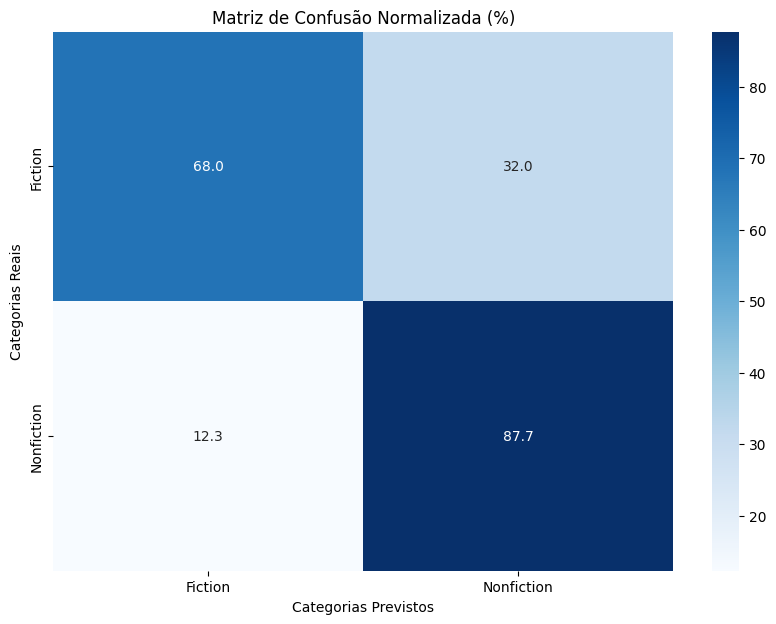

In [47]:
# Trazendo a matriz de confusão normalizada
# Rótulos únicos ordenados
labels = sorted(set(actual_cats) | set(predicted_cats))

# Matriz de confusão (contagens)
cm = confusion_matrix(actual_cats, predicted_cats, labels=labels)

# Normalização por linha (por categoria real)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# DataFrame formatado
confusion_matrix_percent_df = pd.DataFrame(cm_percent, index=labels, columns=labels)

# Plotando
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_percent_df, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.xlabel("Categorias Previstos")
plt.ylabel("Categorias Reais")
plt.title("Matriz de Confusão Normalizada (%)")
plt.show()


- Com as informações acima tivemos uma taxa de acerto grande considerando um modelo de LLM zero-shot. O que pode ser utilizado para prever as categorias ausentes.

In [55]:
isbns = []
predicted_cats = []

missing_cats = books.loc[books["simple_categories"].isna(), ["isbn13", "description"]].reset_index(drop=True)

for i in tqdm(range(0, len(missing_cats))):
    sequence = missing_cats["description"][i]
    predicted_cats += [generate_predictions(sequence, fiction_categories)]
    isbns += [missing_cats["isbn13"][i]]

100%|██████████| 1454/1454 [02:28<00:00,  9.80it/s]


In [56]:
missing_predicted_df = pd.DataFrame({"isbn13": isbns, "predicted_categories": predicted_cats})
missing_predicted_df

,isbn13,predicted_categories
0,9780002261982,Fiction
1,9780006280897,Nonfiction
2,9780006280934,Nonfiction
3,9780006380832,Nonfiction
4,9780006470229,Fiction
...,...,...
1449,9788125026600,Nonfiction
1450,9788171565641,Fiction
1451,9788172235222,Fiction
1452,9788173031014,Nonfiction


In [57]:
# Acrescentados os dados ao dataframe final
books = pd.merge(books, missing_predicted_df, on="isbn13", how="left")
books["simple_categories"] = np.where(books["simple_categories"].isna(), books["predicted_categories"], books["simple_categories"])
books = books.drop(columns = ["predicted_categories"])
books

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,9788172235222,8172235224,Mistaken Identity,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,Mistaken Identity,9788172235222 On A Train Journey Home To North...,Fiction
5193,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...,Nonfiction
5194,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...,Fiction
5195,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction


In [58]:
# Salvando a base de dados com as categorias

# Drop colunas que não serão utilizadas e salvas o arquivos em .csv
load_dotenv()  # carrega as variáveis do .env

# pega o caminho da variável de ambiente e converte em Path
path = Path(os.getenv("DATASETS_PATH"))
path.mkdir(parents=True, exist_ok=True)  # cria a pasta se não existir

(
    books
    .to_csv(f"{path}/books_with_categories.csv", index=False)
)